# Classification

Loading standard libraries

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Loading internal abstractions

In [2]:
sys.path.append('..')
from kernel import KernelComputer, KernelRegressor
from dataloader import LIBSVMLoader, FoldsGenerator

Randomness reproducibility

In [3]:
np.random.seed(0)

### Choose datasets to play with

In [4]:
names = LIBSVMLoader.datasets
names = ['dna', 'svmguide2']
# names = ['segment', 'vowel']

### Choose a kernel

In [5]:
kernel = 'Gaussian'  # 'Gaussian', 'Laplacian', 'Linear'

### Choose hyparameters for the simulations

In [6]:
nb_folds = 8                                              # number of folds
corruptions = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]  # corruptions to test
sigmas = [1e2, 5e0, 1e0, 5e-1, 1e-1, 1e-2]                # different kernel parameters to test
lambdas = [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3]          # different regularizations to test

Internal main script

In [7]:
_kernel = KernelComputer(kernel, sigma=1)
kernel_reg = KernelRegressor(_kernel)

err_ac, err_il = {}, {}
shape_err = (len(corruptions), nb_folds, len(sigmas), len(lambdas))

for name in names:
    print(name)
    
    loader = LIBSVMLoader(name)
    x, y = loader.get_trainset()
    
    index_to_corrupt = np.argmax(y.sum(axis=0))

    S = np.empty((*y.shape, len(corruptions)))
    for i, corruption in enumerate(corruptions):
        S[..., i] = loader.skewed_corruption(y, corruption, index_to_corrupt)
#         S[..., i] = loader.synthetic_corruption(y, corruption)
        
    err_ac[name]= np.empty(shape_err)
    err_il[name]= np.empty(shape_err)
    
    floader = FoldsGenerator(x, y, S, nb_folds=nb_folds)
    
    for fold in range(nb_folds):

        (x_train, S_train), (x_test, y_test) = floader()
        y_test = np.argmax(y_test, axis=1)
        kernel_reg.set_support(x_train)
        n_train, dim = x_train.shape
        
        for i_s, c_sigma in enumerate(sigmas):
            sigma = c_sigma * dim
            kernel_reg.update_sigma(sigma)

            for i_l, c_lambda in enumerate(lambdas):
                lambd = c_lambda / np.sqrt(n_train)
                kernel_reg.update_lambda(lambd)
                alpha = kernel_reg(x_test)

                for i_c, corruption in enumerate(corruptions):

                    s_train = S_train[..., i_c]
                    
                    y_il = np.argmax(alpha @ s_train, axis=1)
                    
                    s_train = s_train / s_train.sum(axis=1)[:, np.newaxis]
                    y_ac = np.argmax(alpha @ s_train, axis=1)
                        
                    err_ac[name][i_c, fold, i_s, i_l] = (y_ac != y_test).mean()
                    err_il[name][i_c, fold, i_s, i_l] = (y_il != y_test).mean()                  

dna
svmguide2


In [8]:
n_c = len(corruptions)
mus, stds = np.empty((len(names), 2, n_c)), np.empty((len(names), 2, n_c))
for i, name in enumerate(names):
    for j, err in zip([0,1], [err_ac, err_il]):
        tmp = err[name].reshape((len(corruptions), nb_folds, -1))
        mu = tmp.mean(axis=-1)
        ind = mu.argmin(axis=1)
        for k in range(len(corruptions)):
            mus[i, j, k] = mu[k, ind[k]]
            stds[i, j, k] = tmp[k, ind[k]].std()
    mus[i, :, -1] = mus[i, :, -1].mean()
    stds[i, :, -1] = stds[i, :, -1].mean()

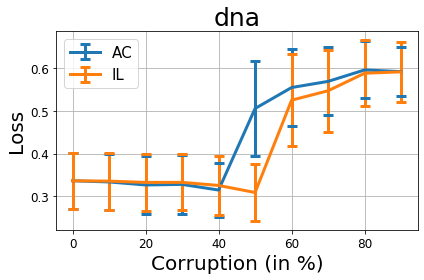

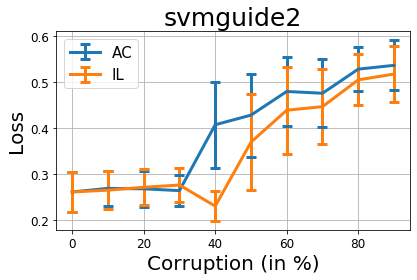

In [9]:
for i, name in enumerate(names):
    fig, ax = plt.subplots()
    a = ax.errorbar([100*i for i in corruptions[:-1]], mus[i, 0][:-1], .5*stds[i, 0][:-1], capsize=5, linewidth=3, capthick=3)
    b = ax.errorbar([100*i for i in corruptions[:-1]], mus[i, 1][:-1], .5*stds[i, 1][:-1], capsize=5, linewidth=3, capthick=3)
    ax.legend([a, b], ['AC', "IL"], prop={'size':15})
    ax.grid()
    ax.set_title(name, size=25)
    ax.set_ylabel('Loss', size=20)
    ax.set_xlabel('Corruption (in %)', size=20)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    fig.savefig(name + '.pdf')